## Setup Environment & Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from prophet import Prophet
import tqdm as notebook_tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta  
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error 

  

pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
sns.set_theme()

c:\Users\Steve\anaconda3\envs\citibike\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trips, stations = utils.upload_data()
trips_2 = utils.filter_outliers(trips, 99, 80)
agg = trips.groupby(['date']).size()
agg.index = pd.to_datetime(agg.index)
agg = agg.asfreq("D")

## Validate Data

In [4]:
delta = agg.index.max() - agg.index.min()
delta.days+1

1157

In [5]:
agg.shape[0]

1157

In [6]:
agg.loc[agg.isna()]

date
2016-01-23   NaN
2016-01-24   NaN
2016-01-25   NaN
2016-01-26   NaN
Freq: D, dtype: float64

In [7]:
agg = agg.interpolate(method='linear')

## Train Test Split

In [13]:
test_days = int(agg.shape[0]*.20)
train = agg.iloc[:-test_days]
test = agg.iloc[-test_days:]

## Seasonal Decomposition

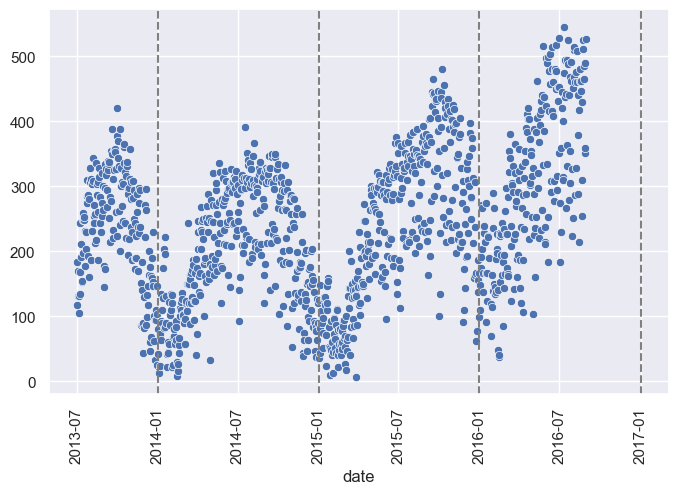

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(agg, ax=ax)
ax.tick_params(axis='x', rotation=90)
start = dt.datetime(2014, 1, 1)
ax.axvline(start, linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=1), linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=2), linestyle='--', color='gray')
ax.axvline(start+relativedelta(years=3), linestyle='--', color='gray')

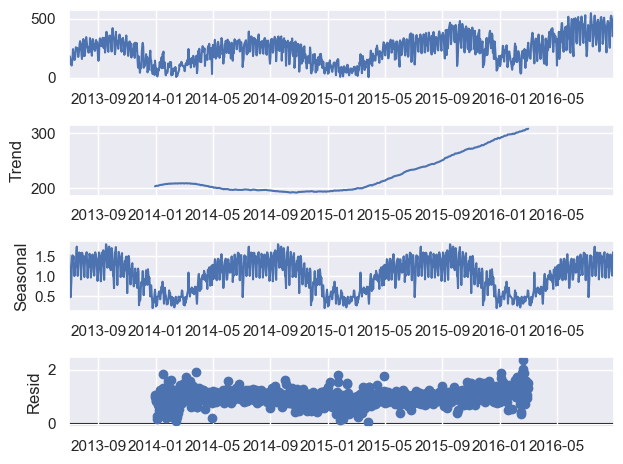

In [13]:
decomposition = seasonal_decompose(agg, 
                                   model = 'multiplicative', 
                                   period = 365)
decomposition.plot();

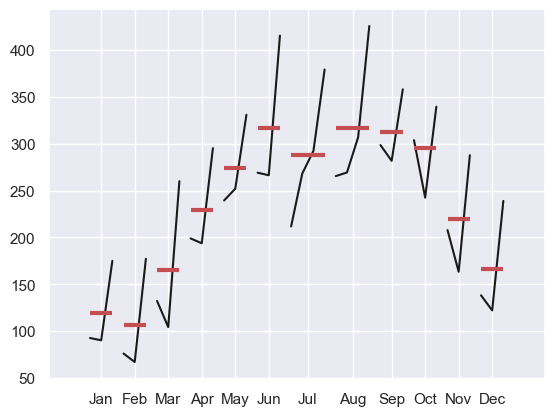

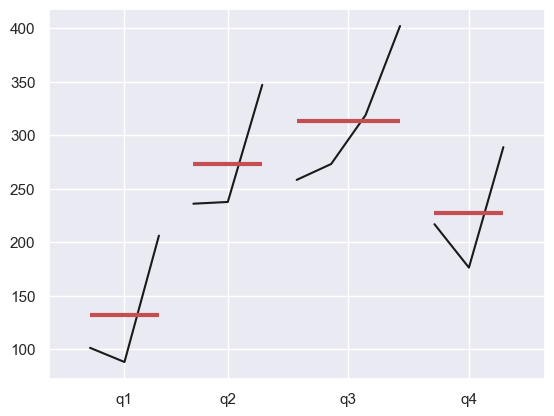

In [36]:
month_plot(agg.resample(rule = 'MS').mean());
quarter_plot(agg.resample(rule = 'Q').mean());

## Holt Winters

c:\Users\Steve\anaconda3\envs\citibike\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


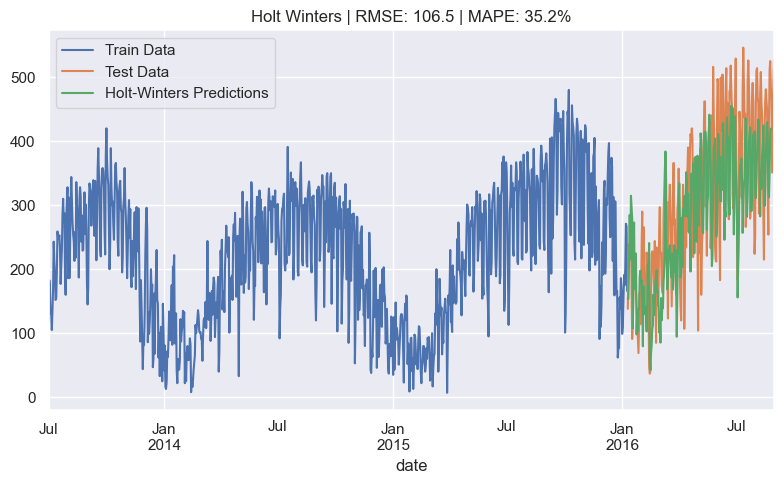

In [114]:
fig, ax = plt.subplots(figsize=(8,5))
ax.tick_params(axis='x', rotation=90)


model = ExponentialSmoothing(endog = train,
                             trend = 'add',
                             seasonal = 'mul',
                             seasonal_periods = 365).fit()
hw_pred = model.forecast(steps = len(test)).rename("HW")
hw_rmse = mean_squared_error(test, hw_pred, squared = False)
hw_mape = utils.mape(test, hw_pred)

train.plot(ax=ax, label='Train Data')
test.plot(ax=ax, label='Test Data')
hw_pred.plot(ax=ax, label='Holt-Winters Predictions')
ax.set_title("Holt Winters | RMSE: {:.1f} | MAPE: {:.1%}".format(hw_rmse, hw_mape))
ax.legend()
fig.tight_layout()
fig.savefig('images/holt_winters_pred.png')

## SARIMA

In [52]:
trips['Date'] = pd.to_datetime(trips['date']) - pd.to_timedelta(7, unit='d')
agg_w = trips.groupby([pd.Grouper(key='Date', freq='W-MON')]).size().sort_index()

test_weeks = int(agg.shape[0]*.20)
train_w = agg.iloc[:-test_weeks]
test_w = agg.iloc[-test_weeks:]

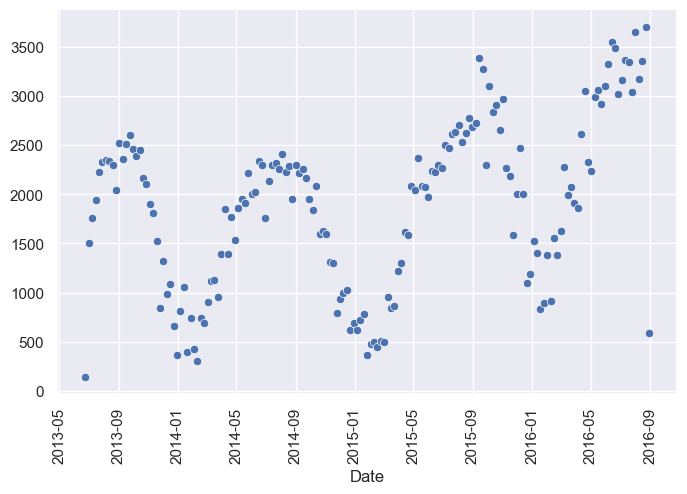

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(agg_w, ax=ax)
ax.tick_params(axis='x', rotation=90)

In [55]:
# from pmdarima import auto_arima
# model = auto_arima(y = train_w,
#                    m = 52,
#                    seasonal =True,
#                    stepwise = True,
#                    trace=True)
# # model.summary()

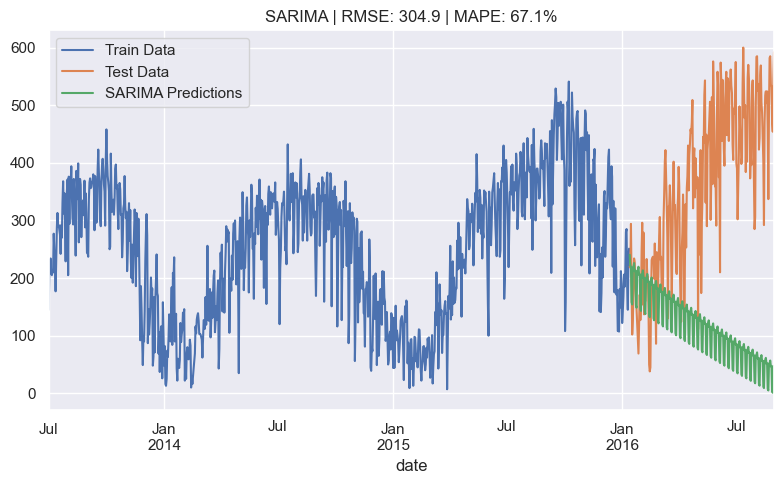

In [56]:
fig, ax = plt.subplots(figsize=(8,5))
ax.tick_params(axis='x', rotation=90)

sarima_pred = model.predict(n_periods= test_days)
sarima_rmse = mean_squared_error(test, sarima_pred, squared = False)
sarima_mape = utils.mape(test, sarima_pred)

train.plot(ax=ax, label='Train Data')
test.plot(ax=ax, label='Test Data')
sarima_pred.plot(ax=ax, label='SARIMA Predictions')
ax.set_title("SARIMA | RMSE: {:.1f} | MAPE: {:.1%}".format(sarima_rmse, sarima_mape))
ax.legend()
fig.tight_layout()
fig.savefig('images/sarima_pred.png')